In [23]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
import skimage
from skimage import io, transform
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
from PIL import Image
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [ ]:
# Path to images
image_path = 'C:/Users/Zachery Key/Desktop/Forge/NeuralNet_Project/Images/'

# Path to test dataset
test_path = 'C:/Users/Zachery Key/Desktop/Forge/NeuralNet_Project/Images/data_test.csv'

# Path to train dataset 
train_path = 'C:/Users/Zachery Key/Desktop/Forge/NeuralNet_Project/Images/data_train.csv'

In [24]:
# Get a transfer dataset 
device = torch.device('cpu')
net = tv.models.resnet18(pretrained=True)
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# Load in the data
# loading dataset
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(train)
print('\n')
print(test)

     Unnamed: 0                    path  class_id  minifigure_name_x  \
0           295     marvel/0001/002.jpg         1         SPIDER-MAN   
1           300     marvel/0001/003.jpg         1         SPIDER-MAN   
2           299     marvel/0001/009.jpg         1         SPIDER-MAN   
3           298     marvel/0001/010.jpg         1         SPIDER-MAN   
4           297     marvel/0001/005.jpg         1         SPIDER-MAN   
..          ...                     ...       ...                ...   
335         182  star-wars/0015/007.jpg        36  EMPEROR PALPATINE   
336         180            test/071.jpg        36  EMPEROR PALPATINE   
337         179  star-wars/0015/005.jpg        36  EMPEROR PALPATINE   
338         184  star-wars/0015/006.jpg        36  EMPEROR PALPATINE   
339         181            test/073.jpg        36  EMPEROR PALPATINE   

                   tmp_name  minifigure_name_y  
0            1 - SPIDER-MAN         SPIDER-MAN  
1            1 - SPIDER-MAN         S

In [26]:
#Convert the csv into a torch dataset
class LEGODataSet(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, img_size, transform=None):
        self.df = pd.read_csv(csv_file)[['path','class_id']]
        #Dropping unnecessary columns
        self.root_dir = root_dir
        #Added Image Size
        self.img_size = img_size
        self.transform = transform


    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        path = image_path + row['path']
        img = io.imread(path)
        img = skimage.transform.resize(img, self.img_size, anti_aliasing=True)
        #Added y to dict to showcase output labels
        #We're doing class_id - 1 because we want the output to be from 0 to N
        y = torch.tensor(row['class_id']-1, dtype=torch.long)
        
        if self.transform:
            img = self.transform(img)
        
        sample = {'image': img, 'id_min_1': y}
        #Returns as dict
        return sample

# Normalize, rescale, and "tensorizing"   
norm_transform = tv.transforms.Compose([
                                tv.transforms.ToTensor(),
                                #VERSATILE MEAN/STD FROM IMAGENET
                                tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])
                                      ])    
    
#CHANGE ACCORDINGLY (ROOTDIR)
torch_lego_train = LEGODataSet(csv_file = train_path, 
                               root_dir = image_path,
                               img_size = (256,256),
                               transform = norm_transform
                              )
torch_lego_test = LEGODataSet(csv_file = test_path, 
                              root_dir = image_path,
                              img_size = (256,256),
                              transform = norm_transform
                             )

dataloader_train = torch.utils.data.DataLoader(torch_lego_train, batch_size = 4, shuffle = True)
dataloader_test = torch.utils.data.DataLoader(torch_lego_test, batch_size = 4, shuffle = True)

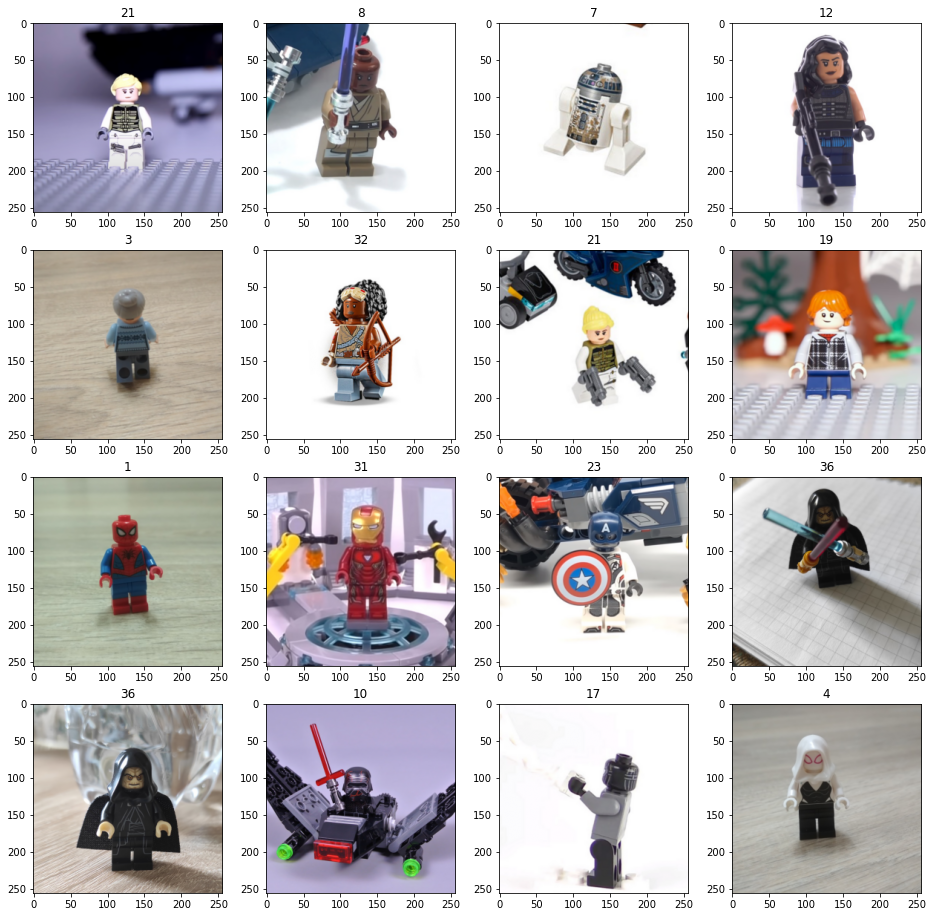

In [27]:
#For loop to normalize all train
fig = plt.figure(figsize=(16, 16))
#Iterate through the torch dataset with dataloader and enumerate
for i, batch in enumerate(dataloader_train):
    #Plus one over here to properly match the class_ids
    images, ids = batch['image'], batch['id_min_1']+1
    for j in range(len(images)):
        plt.subplot(4, 4, 4 * i + j + 1)
        norm_view_img = np.array(images[j]).transpose(1,2,0)
        #Just reversing normalization process in below line
        reg_view_img = norm_view_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        #REG_VIEW_IMG shows regular image --> NORM_VIEW_IMG shows normalized image
        plt.imshow(reg_view_img)
        plt.title(ids[j].numpy())
    if i==3:
        break

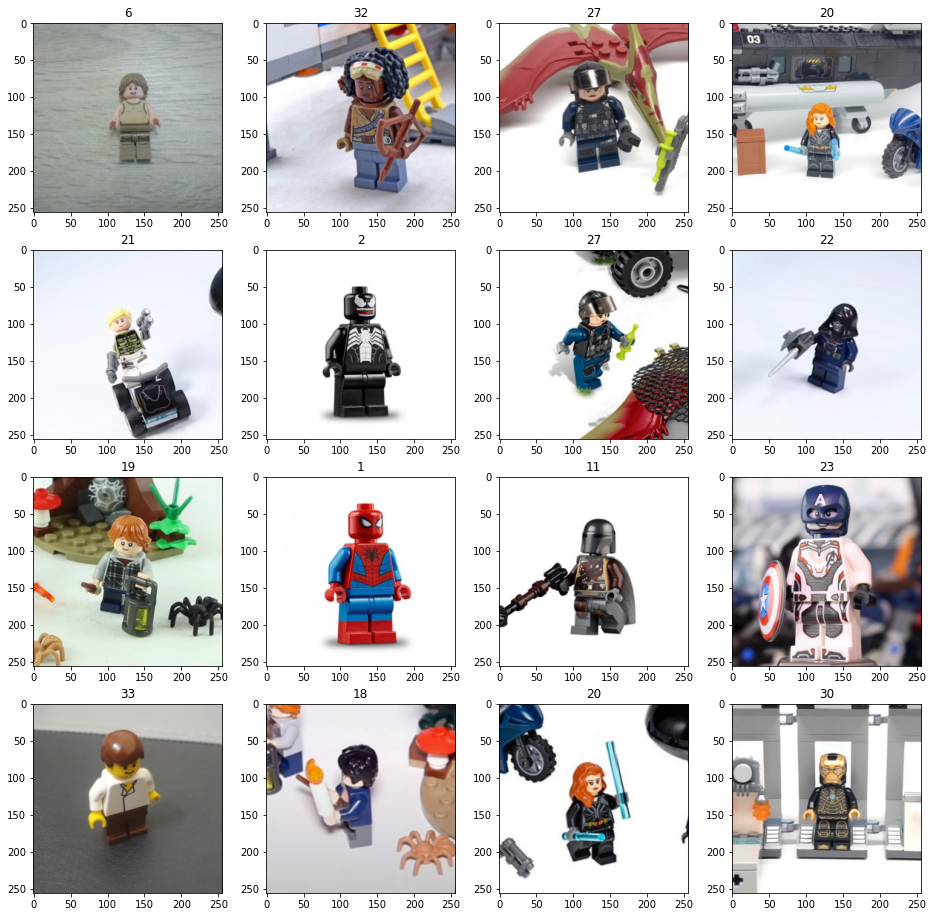

In [28]:
#For loop to normalize all test
fig = plt.figure(figsize=(16, 16))
#Iterate through the torch dataset with dataloader and enumerate
for i, batch in enumerate(dataloader_test):
    #Plus one over here to properly match the class_ids
    images, ids = batch['image'], batch['id_min_1']+1
    for j in range(len(images)):
        plt.subplot(4, 4, 4 * i + j + 1)
        norm_view_img = np.array(images[j]).transpose(1,2,0)
        #Just reversing normalization process in below line
        reg_view_img = norm_view_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        #REG_VIEW_IMG shows regular image --> NORM_VIEW_IMG shows normalized image
        plt.imshow(reg_view_img)
        plt.title(ids[j].numpy())
    if i==3:
        break

# Implement Neural Network 

In [200]:
# Hyperparameters for our Neural Network  
n_epochs = 5           # Number of runs through the model. We divide the data up into  
n_classifiers = 36     # Number of classes that we want to predict for 
momentum = 0.9         # Momentum for optimizer 
learning_rate = .001   # Learning rate for our model 

# User stuff
print_every = 1        # How often do we want to print our performance?  

In [201]:
# Define your loss function, optimizer and features 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

# Define the accuracy of the model 
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

# Define the number of INPUT features in your model 
num_ftrs = net.fc.in_features

# Set the number of OUTPUT features/categories your model is classifying 
net.fc = nn.Linear(num_ftrs, n_classifiers)

In [202]:
# Initialize list to store loss and accuracy data while training the data
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
target_stuff = []

# Iterate through every training epoch 
total_step = len(dataloader_train)
for epoch in range(1, n_epochs+1):
    
    # Initialze loss variables 
    running_loss = 0.0
    correct = 0
    total = 0
    print(f'Epoch {epoch}\n')
    
    # Iterate through every training batch
    for batch_idx, batch in enumerate(dataloader_test):
        
        #Plus one over here to properly match the class_ids
        data_, target_ = batch['image'].to(device), batch['id_min_1'].to(device)
        data_ = data_.float()
        
        optimizer.zero_grad()
        outputs = net(data_)
        
        # Compute the loss of the forward pass 
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        
        # Calculate the number of correct predictions vs. the total number of predictions
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        
        # Print out the epoch number, batch index, total number of steps and loss
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
            
    # Append the perfromance information to the lists to plot later
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / total_step)
    
    # Print out the training loss
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    
    # Record the batch loss, the number of correct 
    batch_loss = 0
    total_t = 0
    correct_t = 0
    
    # Turn requires_grad off into all of the block below. 
    # This is common practice in validation because it makes sure you have not leaked any training
    # data in your testing data AND that 
    with torch.no_grad():
        net.eval()
        
        for batch in dataloader_test:
            # Plus one over here to properly match the class_ids
            data_t, target_t = batch['image'].to(device), batch['id_min_1'].to(device)
            data_t = data_t.float()
            outputs_t = net(data_t)
            
            # Compute the loss of the 
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            
            # Pick the max probability prediction 
            _,pred_t = torch.max(outputs_t, dim=1)
            
            # Count the number of correct predictions in a batch 
            correct_t += torch.sum(pred_t==target_t).item()
            
            # Total number of predictions in a batch
            total_t += target_t.size(0)
            
        # Append the percent correct number of predictions to the accuracy list
        val_acc.append(100 * correct_t/total_t)
        
        # Append the loss value to the loss vector 
        val_loss.append(batch_loss/len(dataloader_test))
        
        # Did we improve our performance from the previous batch 
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        # Save the output of the neural network to a file when the network has improved its performance
        if network_learned:
            # Update our minimum loss if and only if the performance improved from the prior batch
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
            
    # Train the network 
    net.train()

Epoch 1

Epoch [1/5], Step [0/85], Loss: 4.1765
Epoch [1/5], Step [1/85], Loss: 4.1168
Epoch [1/5], Step [2/85], Loss: 3.5864
Epoch [1/5], Step [3/85], Loss: 3.7460
Epoch [1/5], Step [4/85], Loss: 4.1105
Epoch [1/5], Step [5/85], Loss: 3.4642
Epoch [1/5], Step [6/85], Loss: 3.3415
Epoch [1/5], Step [7/85], Loss: 3.8088
Epoch [1/5], Step [8/85], Loss: 4.1559
Epoch [1/5], Step [9/85], Loss: 3.6349
Epoch [1/5], Step [10/85], Loss: 3.8266
Epoch [1/5], Step [11/85], Loss: 3.9914
Epoch [1/5], Step [12/85], Loss: 4.0370
Epoch [1/5], Step [13/85], Loss: 3.6182
Epoch [1/5], Step [14/85], Loss: 4.0334
Epoch [1/5], Step [15/85], Loss: 3.8348
Epoch [1/5], Step [16/85], Loss: 3.8982
Epoch [1/5], Step [17/85], Loss: 3.4806
Epoch [1/5], Step [18/85], Loss: 2.9283
Epoch [1/5], Step [19/85], Loss: 3.2087
Epoch [1/5], Step [20/85], Loss: 3.8456
Epoch [1/5], Step [21/85], Loss: 4.5129

train-loss: 0.9807, train-acc: 1.1765
validation loss: 3.1972, validation acc: 14.1176

Improvement-Detected, save-model

In [135]:
# Show what the output should look like 
n_classes = 32
batch_size = 4

loss = nn.CrossEntropyLoss()
input_ = torch.randn(batch_size, n_classes, requires_grad = True)
target = torch.empty(batch_size, dtype=torch.long).random_(n_classes)
output = loss(input_, target)
print(input_)
print(target)
print(output)

tensor([[ 0.8211, -1.6682,  0.7921,  0.7185, -0.0503,  0.2985,  0.8767, -0.5347,
         -2.8782,  0.6712,  0.4147, -0.2198,  0.4855,  0.8681, -0.4679,  0.9037,
          0.4654,  0.7476,  0.9862,  0.1176,  1.9575,  0.1459, -0.9328, -0.7325,
         -0.5381,  0.3745,  0.7123, -0.0931, -0.2989,  0.3487, -1.4201, -1.0859],
        [ 1.4320,  0.5050, -0.9102, -0.3747,  0.3572,  0.2018, -0.9822,  0.7536,
         -0.4945, -0.4569,  0.0878, -1.6968, -1.6108, -1.1253, -1.1195, -1.9768,
         -1.7167, -0.7178, -0.0205, -0.2407,  0.7177,  0.3233,  0.0157,  0.1573,
          0.2554, -0.2119,  1.0594, -0.5713,  0.2996,  0.1942, -0.6600, -0.8834],
        [-1.0868, -0.3547,  0.7790,  3.2136,  0.4434, -0.9135,  1.0552, -1.0373,
         -0.8034,  0.6665, -0.4409, -1.6588, -0.1344, -0.7585, -0.0053, -0.8808,
          1.6748,  1.1284, -1.0622,  0.1196,  0.4173,  0.7529,  0.3733,  1.0874,
         -1.1951,  0.4194, -0.1997,  0.4526, -0.0728,  0.2660, -0.0156,  0.8996],
        [ 0.0707,  1.2066

In [199]:
next(iter(dataloader_train))

{'image': tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.1933,  2.1890,  2.1975],
           [ 2.2489,  2.2489,  2.2489,  ...,  2.1804,  2.1718,  2.1804],
           [ 2.2489,  2.2489,  2.2489,  ...,  2.2061,  2.1975,  2.1975],
           ...,
           [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
           [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
           [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],
 
          [[ 2.4286,  2.4286,  2.4286,  ...,  2.3717,  2.3673,  2.3761],
           [ 2.4286,  2.4286,  2.4286,  ...,  2.3585,  2.3498,  2.3585],
           [ 2.4286,  2.4286,  2.4286,  ...,  2.3848,  2.3761,  2.3761],
           ...,
           [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
           [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
           [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],
 
          [[ 2.6400,  2.6400,  2.6400,  ...,  2.5834,  2.5877,  2.6095],
    

In [123]:
i = 0
for batch in dataloader_test:
    if i==0:
        data_t, target_t = batch['image'].to(device), batch['id_min_1'].to(device)
        data_t = data_.float()
        print(data_t)
        break
print()
outputs_t = net(data_t)
print(outputs_t)

tensor([[[[0.1854, 0.1854, 0.1854,  ..., 1.8336, 1.8251, 1.7865],
          [0.1768, 0.1768, 0.1768,  ..., 1.8122, 1.8336, 1.8251],
          [0.1768, 0.1768, 0.1768,  ..., 1.7780, 1.8294, 1.8593],
          ...,
          [1.1401, 1.1230, 1.1015,  ..., 1.4954, 1.4954, 1.4997],
          [1.1401, 1.1230, 1.1058,  ..., 1.4954, 1.4954, 1.5040],
          [1.1615, 1.1572, 1.1358,  ..., 1.4783, 1.4869, 1.5040]],

         [[0.1264, 0.1264, 0.1264,  ..., 1.9340, 1.9252, 1.8859],
          [0.1176, 0.1176, 0.1176,  ..., 1.9121, 1.9296, 1.9252],
          [0.1176, 0.1176, 0.1176,  ..., 1.8771, 1.9296, 1.9603],
          ...,
          [1.2556, 1.2425, 1.2293,  ..., 1.6145, 1.6145, 1.6320],
          [1.2293, 1.2206, 1.2075,  ..., 1.6057, 1.6057, 1.6145],
          [1.2293, 1.2206, 1.2162,  ..., 1.6057, 1.6057, 1.6145]],

         [[0.4178, 0.4178, 0.4178,  ..., 2.1258, 2.1215, 2.0823],
          [0.4091, 0.4091, 0.4091,  ..., 2.1084, 2.1302, 2.1215],
          [0.4091, 0.4091, 0.4091,  ..., 2

In [128]:
# Iterate through every training batch
i = 0 
for batch_idx, batch in enumerate(dataloader_test):
    if i ==0: 
        #Plus one over here to properly match the class_ids
        data_, target_ = batch['image'].to(device), batch['id_min_1'].to(device)
        data_ = data_.float()
        outputs = net(data_)
        print(outputs)
        break

tensor([[-0.6166, -0.4916, -0.5066,  0.2180, -0.7647, -0.5675,  2.3030,  1.0329,
         -0.8325, -1.7024,  0.2757,  0.9759, -0.3861,  0.6590, -0.4862,  0.1227,
          1.1391,  1.1953,  0.5035,  0.2606,  0.4953,  0.2508,  0.2238,  0.7370,
         -0.7086,  0.9693,  0.8859, -0.0820, -0.9350,  0.3966,  0.2635, -0.7012,
          0.4596, -0.1552, -0.2412, -0.5158],
        [ 0.6507, -0.4432,  1.3869,  1.4272,  0.8462,  1.7877,  1.1724,  1.3947,
         -0.5600, -0.4888,  0.8614,  0.2708, -0.0356, -0.6315, -0.0558, -0.2276,
          0.0924,  0.8667, -0.2979, -0.9433,  0.6731,  1.2547,  0.2463,  0.2653,
         -0.6864,  1.0273,  0.5939,  0.7276,  0.2952, -0.4272,  0.7851, -1.4734,
          0.1384, -0.2528,  0.2668, -0.0172],
        [ 1.0897, -1.5576,  1.6015,  0.9795,  0.2870,  0.1674,  0.9504,  1.0620,
          1.5467, -0.0349, -0.1019,  0.9076,  0.5709,  0.3680, -0.4141, -1.2798,
          0.1850,  0.4147,  0.3830,  0.6493,  0.8999,  1.4933,  0.2525,  1.1890,
         -0.1370,